In [88]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import billboard
import string
#import applemusicpy
import lyricsgenius
#import SpotifyCharts as sCharts
import csv
import os
from textstat.textstat import textstat
import threading as thread
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn import linear_model, mixture
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from collections import Counter

In [3]:
path = "C:/Users/Chaitu Konjeti/SongPopularityPredictionAlgorithm/output"
genius = lyricsgenius.Genius("Xf0XfBJTZon0Sra2rGV56TAXp6jOUaLJVhmHxqbTW5mp-j6S2NVcmHWSLQ29v0dk")

In [4]:
try:
    os.mkdir(path)
except:
    pass

In [5]:
def writeSongCharacteristics(i, billboardChart, songs):
    key = str(billboardChart[i].title + billboardChart[i].artist)

    if key not in songs:
        song = billboardChart[i]
        title = billboardChart[i].title
        artist = song.artist
        peakpos = song.peakPos
        lastpos = song.lastPos
        numWeeks = song.weeks
        currentPos = song.rank
        isNew = song.isNew
        lyrics = genius.search_song(title, artist).lyrics
        row = [title, artist, lyrics, peakpos, lastpos, numWeeks, currentPos, isNew]
        songs[key] = row

    if key in songs:
        if billboardChart[i].peakPos != songs.get(key)[3]:
            newRow = songs.get(key)
            newRow[3] = billboardChart[i].peakPos
            songs[key] = newRow
        if billboardChart[i].weeks != songs.get(key)[5]:
            newRow = songs.get(key)
            newRow[5] = billboardChart[i].weeks
            songs[key] = newRow

In [6]:
def getAllSongData(startMonth, startYear, endMonth, endYear, numSongs):
    for year in range(startYear, endYear + 1):
        thread.Thread(None, target=yearlySongData, args=(year, startMonth, endMonth, numSongs)).start()

In [7]:
def yearlySongData(year, startMonth, endMonth, numSongs):
    for month in range (startMonth, endMonth + 1):
            thread.Thread(None, target=monthlySongData, args=(year, month, numSongs)).start()

In [9]:
def monthlySongData(year, month, numSongs):
        outputFileName = "C:/Users/Chaitu Konjeti/SongPopularityPredictionAlgorithm/output/billboardHot100_Lyrics_{}_{}.csv".format(year, month)

        with open(outputFileName, 'a+', newline='', encoding='utf-8') as outputFile:
            songs = {}
            day = 1
            dataWriter = csv.writer(outputFile)

            while (day <= 31):
                if month in range(1, 10):
                    try:
                        billboardChart = billboard.ChartData('hot-100', date = "{}-{:02d}-{}".format(year, month, day))
                        for i in range(0, numSongs):
                            try:
                                writeSongCharacteristics(i, billboardChart, songs)
                            except:
                                pass
                    except:
                        pass

                elif month in range(10, 13):
                    try:
                        billboardChart = billboard.ChartData('hot-100', date = "{}-{}-{}".format(year, month, day))
                        for i in range(0, numSongs):
                            try:
                                writeSongCharacteristics(i, billboardChart, songs)
                            except:
                                pass
                    except:
                        pass
                day += 5

            for key in songs:
                if (len(songs[key][2]) < 10000):
                    dataWriter.writerow(songs[key])

In [112]:
def lyric_preprocessing(dir):
    for filename in os.listdir(dir):
        data = []
        sid = SentimentIntensityAnalyzer()
        with open(dir + filename, encoding='utf-8', mode='r+') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                temp = row
                num_positive = 0
                num_negative = 0
                num_neutral = 0
                dale_chall_score = 0
                #print(row[0])
                lyrics = row[2]
                lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
                lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
                #print(lyrics)
                #this_sentence = lyrics.decode('utf-8')
                #numlines = 0
                for line in lyrics.splitlines():
                    #print(line)
                    comp = sid.polarity_scores(line)
                    #print(comp)
                    comp = comp['compound']
                    if comp >= 0.5:
                        num_positive += 1
                    elif comp > -0.5 and comp < 0.5:
                        num_neutral += 1
                    else:
                        num_negative += 1

                    #numlines += 1

                temp.append(num_positive)
                temp.append(num_neutral)
                temp.append(num_negative)
                temp.append(textstat.dale_chall_readability_score(lyrics))
                temp.append(textstat.difficult_words(lyrics))
                temp.append(lyrics)
                data.append(temp)
                #print(temp)
            outputFileName = "C:/Users/Chaitu Konjeti/song-popularity-prediction-algorithm/processed/" + filename

            with open(outputFileName, 'a+', newline='', encoding='utf-8') as outputFile:
                dataWriter = csv.writer(outputFile)
                for items in data:
                    #print(items)
                    dataWriter.writerow(items)

In [ ]:
getAllSongData(1, 2000, 12, 2019, 100)

In [125]:
lyric_preprocessing("output/")

In [144]:
X = []
y = []

In [145]:
dir = 'C:/Users/Chaitu Konjeti/song-popularity-prediction-algorithm/processed/'

In [146]:
for filename in os.listdir(dir):
    with open(dir + filename, encoding='utf-8-sig', mode='r') as csv_file:
        df = pd.read_csv(dir + filename, header = None)
        #print(df.head())
        df.columns = ['title', 'artist', 'original', 'peakpos', 'lastpos', 'numWeeks', 'currentPos', 'isNew', 'pos', 'neu', 'neg', 'dale', 'diff', 'lyrics']
        for lyric in df['lyrics']:
            X.append(lyric)
        for pos in df['currentPos']:
            y.append(pos)

In [147]:
tokens = []
for post in X:
    tokens += word_tokenize(post)
stop_words = ["I", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
tokens = [w for w in tokens if not w in stop_words]

tokens = [word for word in tokens if word.isalpha()]
# print(tokens)

In [156]:
freq = Counter(tokens)
print(freq)

# final_words = []
# for word in tokens:
#     if freq[word] < 100:
#         final_words.append(word)
#print(final_words)


Counter({'got': 344, 'know': 340, 'like': 325, 'You': 298, 'And': 293, 'yeah': 277, 'na': 234, 'back': 227, 'love': 224, 'ai': 197, 'nigga': 189, 'get': 179, 'wan': 173, 'gon': 172, 'go': 150, 'let': 145, 'want': 143, 'see': 136, 'time': 131, 'say': 130, 'We': 127, 'It': 127, 'never': 126, 'But': 126, 'bitch': 125, 'make': 120, 'baby': 119, 'fuck': 118, 'take': 114, 'uh': 113, 'She': 110, 'one': 109, 'keep': 109, 'need': 108, 'Yeah': 106, 'Oh': 105, 'Baby': 105, 'Christmas': 104, 'way': 99, 'ca': 98, 'tell': 98, 'niggas': 98, 'Do': 94, 'feel': 88, 'All': 86, 'could': 85, 'shit': 82, 'heart': 81, 'What': 78, 'If': 78, 'When': 76, 'ooh': 76, 'put': 76, 'Just': 70, 'My': 70, 'hate': 67, 'oh': 66, 'So': 65, 'right': 64, 'girl': 63, 'That': 62, 'away': 61, 'Let': 61, 'ta': 61, 'He': 61, 'ayy': 60, 'ya': 60, 'The': 60, 'come': 59, 'life': 58, 'To': 58, 'really': 58, 'give': 58, 'This': 57, 'around': 56, 'thing': 56, 'ever': 55, 'still': 54, 'good': 54, 'tryna': 53, 'They': 53, 'said': 52, 'N

In [157]:
vocabulary = set(tokens)
# print(vocabulary)
print(len(vocabulary))

4816


In [158]:
frequency_dist = nltk.FreqDist(final_words)

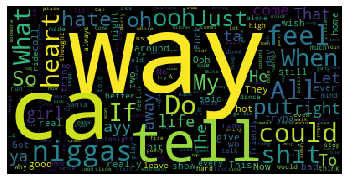

In [159]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [152]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
X = count_vectorizer.fit_transform(X)
y = np.asarray(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
clf = LogisticRegression(verbose=1)
clf.fit(X_train, y_train)

C:\Users\Chaitu Konjeti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitu Konjeti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)

In [9]:
clf.score(X_train, y_train)

0.4450963956412406

In [10]:
pred = clf.predict(X_test)

In [11]:
pred

array([100,  99,  73,  34,  96,   5,  75,  10,  29,  52,  99,  81,  91,
         1,  99,  44,  15,  20, 100,   2,  73,  67,  75, 100,  80,  59,
        45,  95,  96,  87,  47,  61,  72,  69,  44,  82,  99,  43,  89,
        29,  30,   8,  78,  79,  34,  28,  92,  76,  69,  29,  41,   5,
        87,  85,  80,  96,  53,  14,  74,  58,  88,  15,  75,  26,  76,
        49,  59,  87,  10,  74,  29,  14,  26,  74,  47,  72,  47,  80,
        22,  43,  97,  44,  80,  83,   2,  83,  41,  34,  95,  47,   3,
        11,  40,  43,  87,  63,  58,  95,   1,  27,  97,  87,   8,  78,
        43,  46,   8,   2,   5,  74,  14,  47,  38,   4,  47,  69,  13,
        40,  99,  58,  96,  58,  61,  29,  16,  44,  95,  60,  10,  92,
        30,  95,  20,  23,  14,  14,  77,  75,  92,  63,  98,  70,  22,
         8,  54,  13,  89,  69,  74,   8,  87,  91,  20,  15,  14,  35,
        42,  58,  48,  76,  92, 100,  49,  50,   8,  16,  38,  83,   1,
        38,   1,   5,  17,   2,  97,  17,  44,  72,  29,  34,  3

In [12]:
y_test

array([ 97,  34,  42,  28,  77,  39,  55,  19,  98,  98,  16,  86,  85,
        23,  71,  16,  31,  26,  89,  15,  48,  47,  47,  70,  99,  33,
        51,  71,  87,  68,  98,  82,  77,  69,  42,  90,   7,  40,  57,
        81,   5,  26,  85,  99,  38,  26,  54,  42,  76,  30,  62,  77,
        56,  87,  87,  67,  44,  15,  56,  67,  37,  38,  93,  41,  86,
        73,  98,  49,  11,  72,  66,   4,  39,  25,  30,  64,  27,  44,
         1,  82,  93,  78,  20,  50,   7,  67, 100,  47,  89,  71,   5,
        17,  51,  26,  93,  69,  61,  58,  13,  19,  79,  57,  30,  86,
        28,  37,  86,  21,  37,  79,  11,  65,  55,  13,  69,  76,  12,
        50,  46,  62,  39,  75,  85,  33,  21,  99,  21,  92,  10,  95,
         5,  78,   4,  57,  25,   2,  68,  13,  63,  52,  52,  76,  42,
        22,  56,  52,  82,  79,  39,  70,  38,  71,  44,  28,   9,   7,
        55,   1,  54,  62,  83,  80,  27,  33,  47,  66,  32,  46,   6,
        61,   5,  56,  59,   3,  81,  34,  51,  96,  94,  29,  1